In [11]:
import pandas as pd
import kagglehub
import os
from sklearn.preprocessing import LabelEncoder

In [2]:
df = kagglehub.dataset_download("ahmedabbas757/coffee-sales")

print("Path to dataset files:", df)

Resuming download from 4194304 bytes (4433029 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/ahmedabbas757/coffee-sales?dataset_version_number=1 (4194304/8627333) bytes left.


100%|██████████| 8.23M/8.23M [00:03<00:00, 1.44MB/s]

Extracting files...


Path to dataset files: C:\Users\LOQ\.cache\kagglehub\datasets\ahmedabbas757\coffee-sales\versions\1


In [3]:
downloaded_files = os.listdir(df)

excel_file = [f for f in downloaded_files if f.endswith('.xlsx')][0]
excel_file_path = os.path.join(df, excel_file)

df = pd.read_excel(excel_file_path)

In [4]:
df.head(5)

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


In [5]:
# drop some columns such as "product_id", "transaction_id" and "store_id"
df.drop(columns = ["transaction_id", "store_location", "product_detail", "product_type"], inplace = True)

In [6]:
# add new column month
df["month"] = df["transaction_date"].dt.month_name()

# add new column day
df["day"] = df["transaction_date"].dt.day_name()

In [7]:
# see unique values in each column

# 1- create new data frame with number of unique value in each column
columnValue = df.nunique().reset_index()

# 2- rename column name
columnValue.rename(columns = {"index" : "Column _name", 0 : "Uniue values"}, inplace = True)

# 3- see columns and number of unique values of each
columnValue

,Column _name,Uniue values
0,transaction_date,181
1,transaction_time,25762
2,transaction_qty,6
3,store_id,3
4,product_id,80
5,unit_price,41
6,product_category,9
7,month,6
8,day,7


In [8]:
df['total_sales'] = df['transaction_qty'] * df['unit_price']

In [9]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Agregasi harian per store
daily_sales = df.groupby(['store_id', 'transaction_date'])['total_sales'].sum().reset_index()

In [12]:
le_cat = LabelEncoder()
df['product_category'] = le_cat.fit_transform(df['product_category'])

le_month = LabelEncoder()
df['month'] = le_month.fit_transform(df['month'])

le_day = LabelEncoder()
df['day'] = le_day.fit_transform(df['day'])

In [13]:
df['month'] = df['transaction_date'].dt.month       # 1 to 12
df['day'] = df['transaction_date'].dt.dayofweek # 0=Mon, 6=Sun

In [14]:
df['transaction_hour'] = pd.to_datetime(df['transaction_time'], format='%H:%M:%S').dt.hour

def get_time_of_day(hour):
    if 5 <= hour < 11:
        return 'Morning'
    elif 11 <= hour < 15:
        return 'Afternoon'
    elif 15 <= hour < 18:
        return 'Evening'
    else:
        return 'Night'

df['time_of_day'] = df['transaction_hour'].apply(get_time_of_day)

In [15]:
df.drop(columns = ["transaction_hour","transaction_time"], inplace = True)

In [16]:
tod_day = LabelEncoder()
df['time_of_day'] = tod_day.fit_transform(df['time_of_day'])

In [17]:
from sklearn.model_selection import train_test_split

features = ['transaction_qty', 'unit_price',
            'product_id', 'product_category']
X = df[features]
y = df['total_sales']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [18]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42
)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=10, random_state=42)

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

MAE: 0.042
RMSE: 1.788
R² Score: 0.885


C:\Users\LOQ\AppData\Local\Temp\ipykernel_25264\2112635146.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feat_names, palette='viridis')


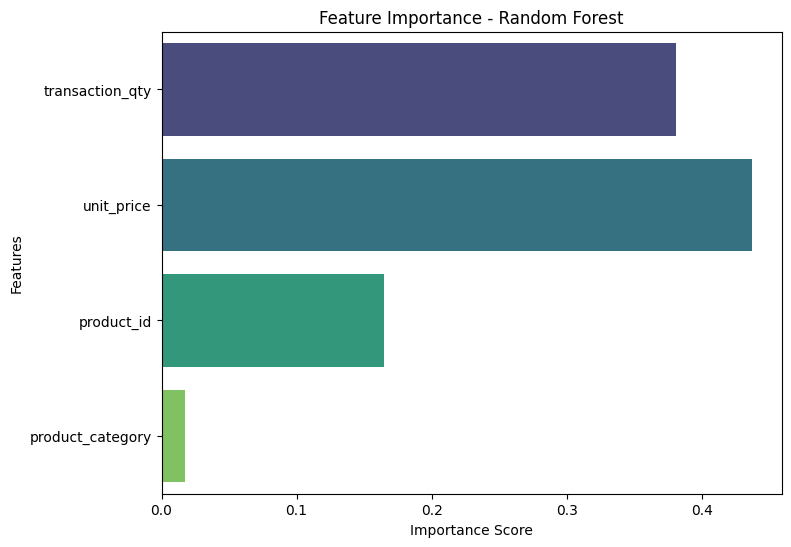

In [24]:
# 1. Feature Importance
plt.figure(figsize=(8,6))
importances = rf.feature_importances_
feat_names = X.columns
sns.barplot(x=importances, y=feat_names, palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

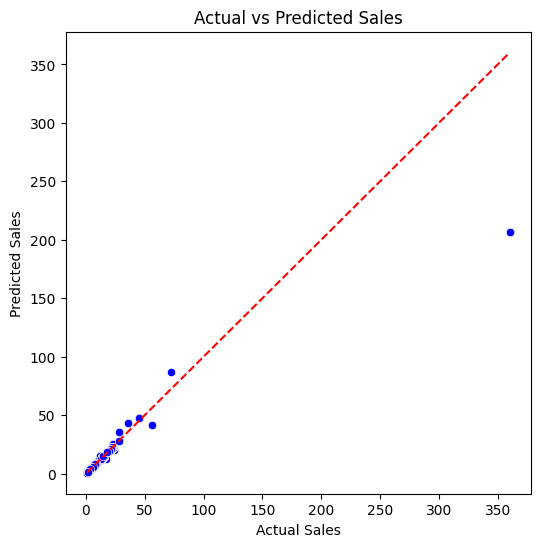

In [25]:
# 2. Scatter Plot: Actual vs Predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.show()

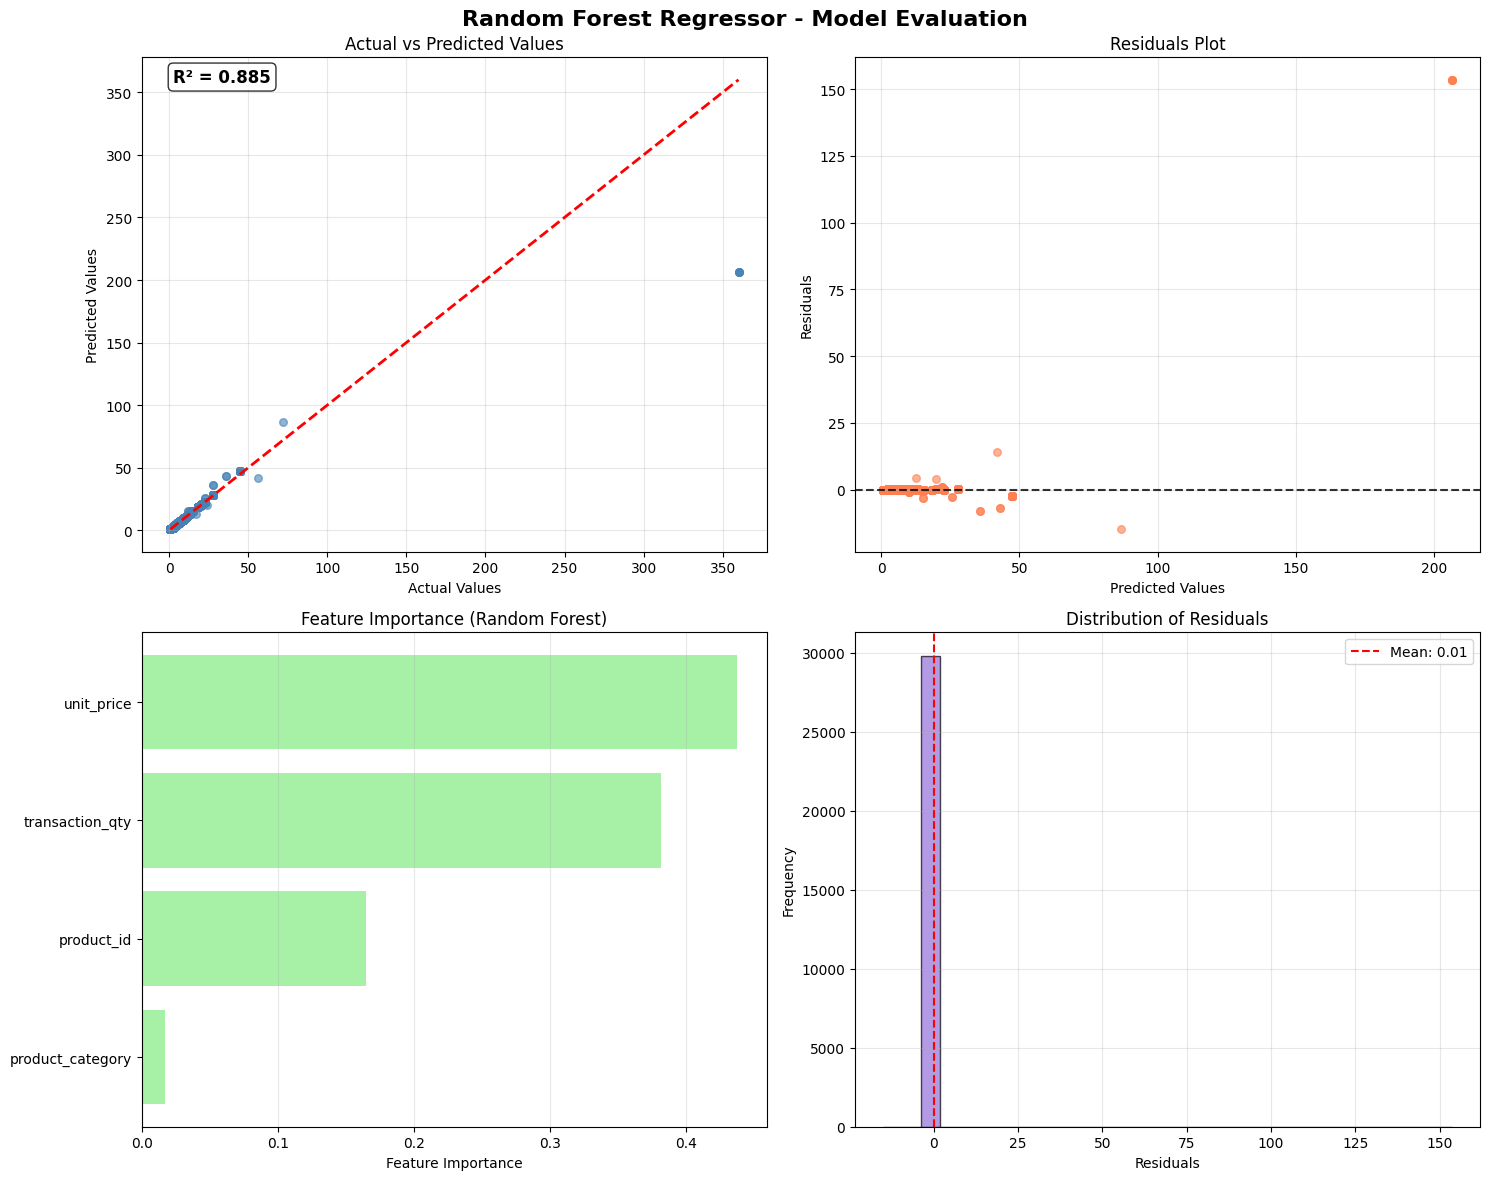

In [26]:

# 1. ACTUAL vs PREDICTED PLOT
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Random Forest Regressor - Model Evaluation', fontsize=16, fontweight='bold')

# Plot 1: Actual vs Predicted
axes[0,0].scatter(y_test, y_pred, alpha=0.6, color='steelblue', s=30)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual Values')
axes[0,0].set_ylabel('Predicted Values')
axes[0,0].set_title('Actual vs Predicted Values')
axes[0,0].grid(True, alpha=0.3)

# Tambahkan R² score pada plot
r2_text = f'R² = {r2:.3f}'
axes[0,0].text(0.05, 0.95, r2_text, transform=axes[0,0].transAxes,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
               fontsize=12, fontweight='bold')

# Plot 2: Residuals Plot
residuals = y_test - y_pred
axes[0,1].scatter(y_pred, residuals, alpha=0.6, color='coral', s=30)
axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.8)
axes[0,1].set_xlabel('Predicted Values')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Residuals Plot')
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Feature Importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=True)

axes[1,0].barh(feature_importance['feature'], feature_importance['importance'],
               color='lightgreen', alpha=0.8)
axes[1,0].set_xlabel('Feature Importance')
axes[1,0].set_title('Feature Importance (Random Forest)')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Plot 4: Error Distribution
axes[1,1].hist(residuals, bins=30, alpha=0.7, color='mediumpurple', edgecolor='black')
axes[1,1].axvline(residuals.mean(), color='red', linestyle='--',
                  label=f'Mean: {residuals.mean():.2f}')
axes[1,1].set_xlabel('Residuals')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of Residuals')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

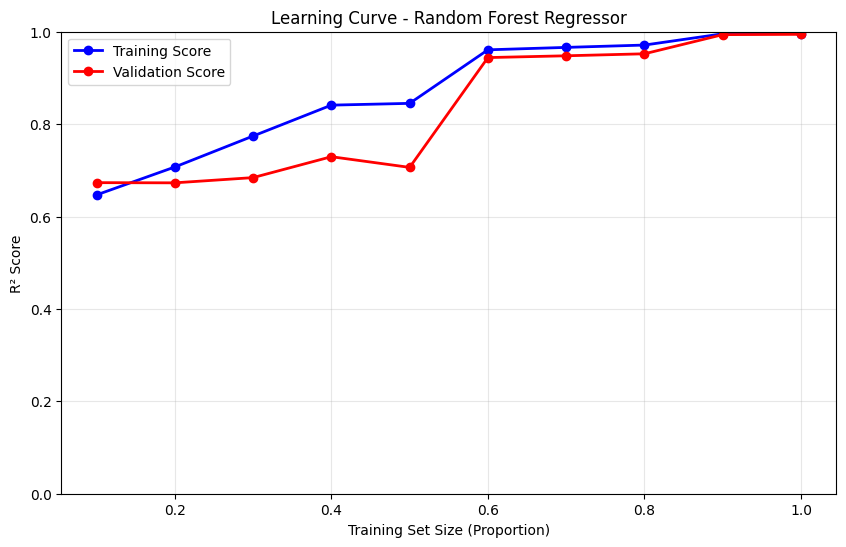

In [27]:
# 2. LEARNING CURVE VISUALIZATION
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Simulasi learning curve dengan berbagai ukuran training set
train_sizes = np.linspace(0.1, 1.0, 10)
train_scores = []
val_scores = []

for size in train_sizes:
    # Ambil subset dari training data
    subset_size = int(size * len(X_train))
    X_subset = X_train.iloc[:subset_size]
    y_subset = y_train.iloc[:subset_size]

    # Train model pada subset
    rf_temp = RandomForestRegressor(
        n_estimators=100, max_depth=10, min_samples_split=5,
        min_samples_leaf=3, max_features='sqrt', random_state=42
    )
    rf_temp.fit(X_subset, y_subset)

    # Evaluasi pada training dan validation set
    train_pred = rf_temp.predict(X_subset)
    val_pred = rf_temp.predict(X_test)

    train_r2 = r2_score(y_subset, train_pred)
    val_r2 = r2_score(y_test, val_pred)

    train_scores.append(train_r2)
    val_scores.append(val_r2)

ax.plot(train_sizes, train_scores, 'o-', color='blue', label='Training Score', linewidth=2)
ax.plot(train_sizes, val_scores, 'o-', color='red', label='Validation Score', linewidth=2)
ax.set_xlabel('Training Set Size (Proportion)')
ax.set_ylabel('R² Score')
ax.set_title('Learning Curve - Random Forest Regressor')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)
plt.show()

In [30]:
import joblib

joblib.dump(rf, "model.joblib")

['model.joblib']